In [1]:
import torchvision
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def npy_loader(path):
    sample = torch.from_numpy(np.load(path)).float()
    return sample

mean, std = [0.00795006, 0.00491375, 0.00303437], [2.09932719, 0.18706343, 0.04582122]

train_set = torchvision.datasets.DatasetFolder('./data/Train', npy_loader, extensions=['.npy'], transform=transforms.Normalize(mean=mean, std=std))
valid_set = torchvision.datasets.DatasetFolder('./data/Valid', npy_loader, extensions=['.npy'], transform=transforms.Normalize(mean=mean, std=std))
test_set = torchvision.datasets.DatasetFolder('./data/Test', npy_loader, extensions=['.npy'], transform=transforms.Normalize(mean=mean, std=std))

#load tensors into dataloaders
batch_size = 64
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)#, pin_memory=True, num_workers=4)
valid_dl = DataLoader(valid_set, batch_size=batch_size, shuffle=True)#, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True)#, pin_memory=True, num_workers=4)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class block(nn.Module):
    def __init__(self, in_size, nfilter, nlayer, skip_connection=False):
        super().__init__()
        
        self.skip_connection, self.nlayer = skip_connection, nlayer
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(in_size, nfilter, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.convlayers = []
        
        for i in range(nlayer-1):
            if i == nlayer-2:
                self.convlayers.append(nn.Conv2d(nfilter, nfilter, kernel_size=3, padding=1))
            else:
                self.convlayers.append(nn.Sequential(
                    nn.Conv2d(nfilter, nfilter, kernel_size=3, padding=1),
                    nn.ReLU()))
        
        self.maxpool = nn.Sequential(
            nn.MaxPool2d(2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(nfilter))
        
        self.convlayers = nn.Sequential(*self.convlayers)
        
    def forward(self, x):
        x_res = self.convlayer1(x)
        x = self.convlayers(x_res)
        if self.skip_connection: x = x + x_res
        return self.maxpool(x)

class BaseNet(nn.Module):
    def __init__(self, nfilters=[2, 64, 128], nlayers=[2, 3], latent_dim=64, conv1=True, skip_connection=False):
        super().__init__()
        
        self.conv1 = conv1

        layers = []
        for idx, (nfilter, nlayer) in enumerate(zip(nfilters[1:], nlayers)):
            layers.append(block(nfilters[idx], nfilter, nlayer=nlayer, skip_connection=skip_connection))
        
        self.convlayers = nn.Sequential(*layers)
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(nfilters[-1], latent_dim, kernel_size=1),
            nn.ReLU())

    def forward(self, x):
        
        x = self.convlayers(x)
        
        if self.conv1:
            x = self.convlayer2(x)
        
        return x.mean([2,3])
    
class Net(nn.Module):
    def __init__(self, which_dim=[0], nfilters=[1, 32, 64, 128], nlayers=[2, 2, 2], latent_dim=64, conv1=True, skip_connection=False):
        super().__init__()
        
        self.which_dim = which_dim
        
        self.net = BaseNet(nfilters=nfilters, nlayers=nlayers, latent_dim=latent_dim, conv1=conv1, skip_connection=skip_connection)
        
        self.fc1 = nn.Sequential(
                    nn.Linear(latent_dim, latent_dim),
                    nn.ReLU())
        self.fc2 = nn.Linear(latent_dim, 1)
        
    def forward(self, x):
        
        x = x[:,self.which_dim,]
        
        x = self.net(x)
        
        x = self.fc1(F.dropout(x, training=self.training, p=0.1))
        x = self.fc2(F.dropout(x, training=self.training, p=0.1))
        
        return torch.sigmoid(x)

In [3]:
from torchinfo import summary

#Check network struct
summary(Net([1,2], [2, 32, 64, 128, 256], [2, 2, 3, 3], 256, skip_connection=True), (batch_size, 3, 125, 125), device="cpu")

Layer (type:depth-idx)                        Output Shape              Param #
Net                                           [64, 1]                   --
├─BaseNet: 1-1                                [64, 256]                 --
│    └─Sequential: 2-1                        [64, 256, 9, 9]           --
│    │    └─block: 3-1                        [64, 32, 63, 63]          9,920
│    │    └─block: 3-2                        [64, 64, 32, 32]          55,552
│    │    └─block: 3-3                        [64, 128, 17, 17]         369,280
│    │    └─block: 3-4                        [64, 256, 9, 9]           1,475,840
│    └─Sequential: 2-2                        [64, 256, 9, 9]           --
│    │    └─Conv2d: 3-5                       [64, 256, 9, 9]           65,792
│    │    └─ReLU: 3-6                         [64, 256, 9, 9]           --
├─Sequential: 1-2                             [64, 256]                 --
│    └─Linear: 2-3                            [64, 256]                 

In [5]:
#find gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from sklearn.metrics import roc_auc_score

metric_logger = {}
for label in ['Train', 'Test', 'Valid', 'Trainb']:
    metric_logger['Accuracy/'+label] = []
    metric_logger['AUC/'+label] = []
    metric_logger['Loss/'+label] = []

#testing function
def runTest(model, dl, epoch, label='Test'):
    model.eval()
    test_loss = 0
    correct, correct_type1 = 0, 0
    outputs, targets = [], []
    with torch.no_grad():
        for data, target in dl:
            
            data, target = data.to(device), target.to(device).unsqueeze(1)
            
            output = model(data)
            
            #compute sum of loss
            test_loss += F.binary_cross_entropy(output, target.float(), reduction='sum').item()
            
            #save predictions for computation of auc
            outputs += output.flatten().tolist()
            targets += target.flatten().tolist()
            
            #compute # of correct prediction
            pred = (output>0.5)
            correct += (pred==target.to(torch.bool)).sum()
            correct_type1 += (  (pred==target.to(torch.bool)) & (target.to(torch.bool))   ).sum()
        
        #compute average loss, accuracy and auc
        test_loss /= len(dl.dataset)
        test_accuracy = correct / len(dl.dataset)
        auc = roc_auc_score(targets, outputs)
        
        correct_type1 = correct_type1.item()
        correct_type2 = (correct - correct_type1).item()
        
        correct_type1 /= sum(targets)/100
        correct_type2 /= (len(targets) - sum(targets))/100
        
    print('\nEpoch: {} {} set: Avg. loss: {:.6f}, AUC :{:.4f}, Accuracy: {}/{} ({:.2f}%), Correct Type 1 {:.2f}%, Type 2 {:.2f}%\n'.format(
        epoch,
        label,
        test_loss, 
        auc,
        correct, len(dl.dataset),
        100. * test_accuracy,
        correct_type1,
        correct_type2))
    
    metric_logger['Accuracy/'+label].append(test_accuracy.item())
    metric_logger['Loss/'+label].append(test_loss)
    metric_logger['AUC/'+label].append(auc)
    
    return auc

In [7]:
def plot_grad_flow(named_parameters, epoch):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
            max_grads.append(p.grad.abs().max().item())
    print(epoch, ave_grads, max_grads)

In [8]:
import sys
import random

log_interval = 50

#training function
def runTrain(model, dl, epoch, optimizer):
    model.train()
    counter = 0
    batch_avg_acc, batch_avg_loss, batch_avg_auc = 0, 0, 0
    
    for batch_idx, (data, target) in enumerate(dl):
        sys.stdout.flush()

        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device).unsqueeze(1)
        
        #add data aug with random flips/rotations
        h_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
        data[h_flip_rand] = data[h_flip_rand].flip(2+1)

        v_flip_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
        data[v_flip_rand] = data[v_flip_rand].flip(3+1)

        rotate_rand = torch.nonzero(torch.randint(0, 2, (data.shape[0], )))
        for to_rotate in rotate_rand:
            data[to_rotate] = transforms.functional.rotate(data[to_rotate],random.random()*360)#, fill=(-0.00795006/2.09932719, -0.00491375/0.18706343, -0.00303437/0.04582122))
        
        output = model(data)

        loss = F.binary_cross_entropy(output, target.float())

        loss.backward()
#         plot_grad_flow(model.named_parameters(), epoch)
        
        optimizer.step()
        
        auc = roc_auc_score(target.flatten().tolist(), output.flatten().tolist())
        
        pred = (output>0.5)
        correct = (pred == target.to(torch.bool)).sum()
        
        train_accuracy = correct / len(data)
        
        batch_avg_acc += train_accuracy
        batch_avg_loss += loss
        batch_avg_auc += auc
        
        counter+=len(data)
        
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}, Batch AUC: {:.4f}, Batch Accuracy: {}/{} ({:.2f}%)\n'.format(
            epoch, counter, len(dl.dataset),
            100. * batch_idx / len(train_dl), loss.item(), 
            auc, correct, len(data), 100. * train_accuracy))
            
    metric_logger['Accuracy/Trainb'].append(batch_avg_acc.item()/(batch_idx+1))
    metric_logger['Loss/Trainb'].append(batch_avg_loss.item()/(batch_idx+1))
    metric_logger['AUC/Trainb'].append(batch_avg_auc.item()/(batch_idx+1))
    print('Train Epoch: {} \tBatch Avg. Loss: {:.6f},  AUC: {:.4f},  Accuracy: {:.4f}\n'.format(
            epoch, metric_logger['Loss/Trainb'][-1],  metric_logger['AUC/Trainb'][-1], metric_logger['Accuracy/Trainb'][-1]))

In [ ]:
import pickle

sys.stdout = open("logs/my_log.txt", "a")

n_epochs = 200

model = Net([1,2], [2, 32, 64, 128, 256], [2, 2, 3, 3], 256, skip_connection=True).to(device)

#define optimizer
optimizer = optim.Adam(model.parameters(),lr=1e-4) #amsgrad=True,
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=2, verbose=True)

#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005, nesterov=True)

#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

#MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)

#list to apply early stopping if valid auc stopped improving
auc_cur, best_auc = -999, -999
stopping_epochs, stopping_epochs_counter = 8, 0

#run train and test
for epoch in range(1, n_epochs + 1):
    
    runTrain(model, train_dl, epoch, optimizer)
    
    runTest(model, train_dl, epoch, label='Train')
    
    runTest(model, test_dl, epoch)
    
    auc_cur = runTest(model, valid_dl, epoch, label='Valid')
    scheduler.step(auc_cur)
    
    torch.save(model, f"models/task2_model.pt")
        
    #do early stopping
    if auc_cur > best_auc:
        best_auc = auc_cur
        stopping_epochs_counter = 0
    else:
        stopping_epochs_counter += 1
        
    if stopping_epochs_counter >= stopping_epochs: 
        print('----------early breaking----------')
        break

with open('logs/metrics.pickle', 'wb') as handle:
    pickle.dump(metric_logger, handle)

In [10]:
!cat logs/my_log.txt

Train Epoch: 1 [64/100286 (0%)]	Batch Loss: 0.690755, Batch AUC: 0.5645, Batch Accuracy: 34/64 (53.12%)

Train Epoch: 1 [3264/100286 (3%)]	Batch Loss: 0.583435, Batch AUC: 0.7675, Batch Accuracy: 44/64 (68.75%)

Train Epoch: 1 [6464/100286 (6%)]	Batch Loss: 0.668244, Batch AUC: 0.6676, Batch Accuracy: 45/64 (70.31%)

Train Epoch: 1 [9664/100286 (10%)]	Batch Loss: 0.562718, Batch AUC: 0.7971, Batch Accuracy: 49/64 (76.56%)

Train Epoch: 1 [12864/100286 (13%)]	Batch Loss: 0.512840, Batch AUC: 0.8522, Batch Accuracy: 48/64 (75.00%)

Train Epoch: 1 [16064/100286 (16%)]	Batch Loss: 0.570866, Batch AUC: 0.7771, Batch Accuracy: 45/64 (70.31%)

Train Epoch: 1 [19264/100286 (19%)]	Batch Loss: 0.559979, Batch AUC: 0.7996, Batch Accuracy: 44/64 (68.75%)

Train Epoch: 1 [22464/100286 (22%)]	Batch Loss: 0.673179, Batch AUC: 0.6687, Batch Accuracy: 38/64 (59.38%)

Train Epoch: 1 [25664/100286 (26%)]	Batch Loss: 0.634848, Batch AUC: 0.7078, Batch Accuracy: 40/64 (62.50%)

Train Epoch: 1 [28864/100286

Accuracy
Number of Epochs 27: Testing 0.7204, Training 0.7205, Valid 0.7215
AUC
Number of Epochs 27: Testing 0.7868, Training 0.7868, Valid 0.7845
Loss
Number of Epochs 27: Testing 0.5584, Training 0.5583, Valid 0.5602
Best Test AUC achieved at Epoch 27: 0.7868
Test AUC achieved at last Epoch: 0.7868


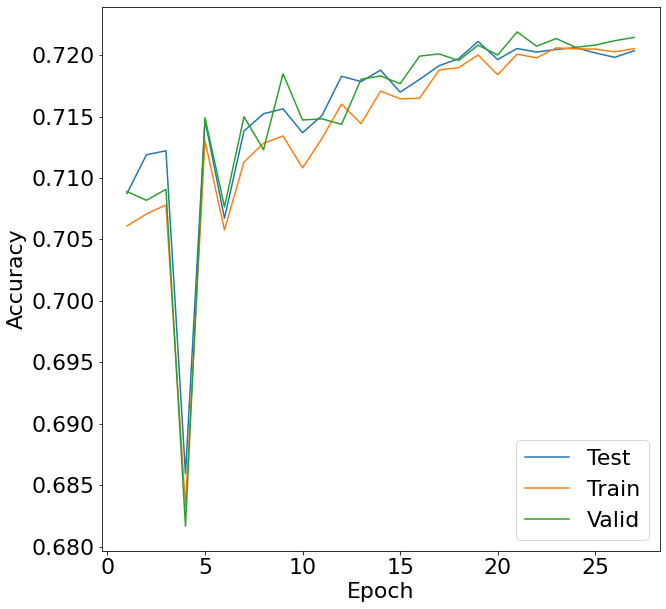

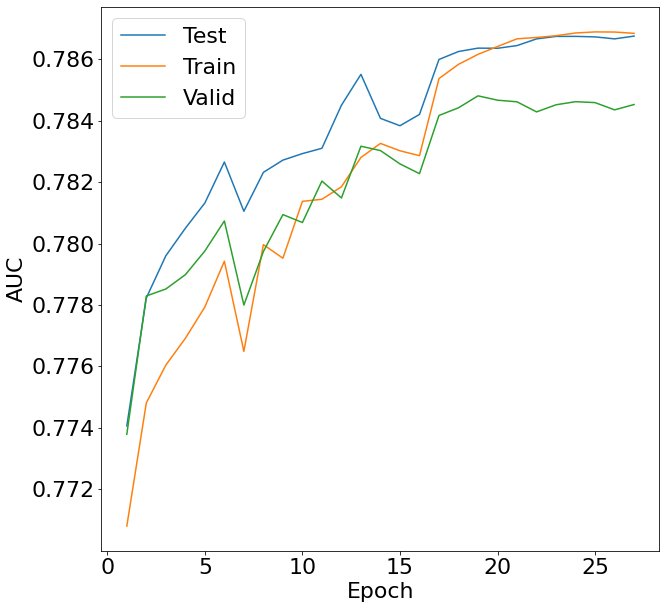

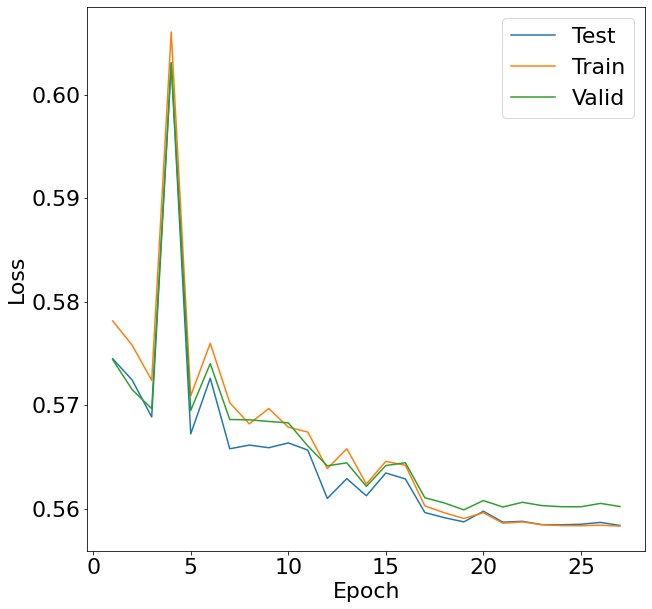

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('logs/metrics.pickle', 'rb') as handle:
    metric_logger = pickle.load(handle)

#Plot training/valid/testing metrics
for metric in set([_.split('/')[0] for _ in metric_logger.keys()]):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 22})
    epochs = len(metric_logger[metric+'/Test'])
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Test'], label='Test')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Train'], label='Train')
    plt.plot(range(1,epochs+1), metric_logger[metric+'/Valid'], label='Valid')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    print(metric)
    print('Number of Epochs {}: Testing {:.4f}, Training {:.4f}, Valid {:.4f}'.format(epochs, metric_logger[metric+'/Test'][-1], metric_logger[metric+'/Train'][-1], metric_logger[metric+'/Valid'][-1]))
    
print('Best Test AUC achieved at Epoch {}: {:.4f}'.format(np.argmax(metric_logger['AUC/Test'])+1, max(metric_logger['AUC/Test'])))
print('Test AUC achieved at last Epoch: {:.4f}'.format(metric_logger['AUC/Test'][-1]))